purpose: generate network colocalization values for Locomotor network and compare NPS scores

# set-up

Note: functions are at bottom of notebook- run first

In [1]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random

In [25]:
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
from rca_functions import *

In [26]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [3]:
random_seed=random.seed(211)

In [4]:
save_fig=True

In [133]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


In [5]:
IBM=['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000']
colour_dict={
    'ext':IBM[1],
    'ext_alt':IBM[0],
    'loco':IBM[4],
    'loco_alt':IBM[3],
    'shared':IBM[2],
    'other':'#CCCCCC'
}

In [102]:
UUIDs={
    'PCNet2.0':'d73d6357-e87b-11ee-9621-005056ae23aa',
    'PCNet2.1':'e9c574f4-e87a-11ee-9621-005056ae23aa',
    'PCNet2.2':'8b4b54fa-e87d-11ee-9621-005056ae23aa'
}

# functions

In [27]:
def import_seedgenes(path,pcol='P',gene_col='GENE NAME',delim='comma', cutoff=None):
    if delim=='comma':
        df=pd.read_csv(path,sep=',')
    else:
        df=pd.read_csv(path,sep='\t')
    if pcol==None:
        print('pvalue column not specified- all genes will be used')
        cutoff=None
    if cutoff=='bonferroni':
        df=df[df[pcol]<0.05/len(df)]
    elif cutoff=='FDR_05':
        df=df[df[pcol]<0.05]
    else:
        print('cutoff not defined/custom- using all genes ')
        df=df
    print(df.head())
    return(df)

In [28]:
def import_interactome(interactome_name=None, UUIDs=UUIDs,ndex_user=None, ndex_password=None,UUID=None):
    """
    Imports a gene interactome from the NDEx database and returns it as a NetworkX graph object. Optionally,
    the function allows for importing using a unique identifier (UUID) or by an interactome name.

    The function checks if the interactome name provided corresponds to a predefined dictionary of UUIDs. If it does, it
    retrieves the network using the specified credentials. If an interactome name is not provided but a UUID is,
    it retrieves the network using the provided UUID. The nodes of pcnet_v14 are relabelled by their gene name rather than ID number.

    Parameters:
    - interactome_name (str, optional): The name of the interactome as defined in the UUIDs dictionary. If not provided
      but a UUID is, the interactome associated with the UUID is imported instead.
    - ndex_user (str, optional): The NDEx account username for accessing private networks.
    - ndex_password (str, optional): The NDEx account password for accessing private networks.
    - UUID (str, optional): A specific UUID to directly download an interactome from NDEx if the interactome name is not used.

    Returns:
    networkx.Graph: A graph object representing the interactome. Nodes and edges represent genes and their interactions, respectively.

    Notes:
    - The function uses the NDEx2 Python client and requires Internet access to NDEx's servers.
    - Depending on the access rights of the NDEx account, private or public interactomes can be retrieved.
    - The function prints the number of nodes and edges of the imported graph for diagnostic purposes.

    Raises:
    - ValueError: If neither an interactome name nor a UUID is provided.
    """    
    interactome_uuid=UUIDs[interactome_name]
    print(interactome_name)
    ndex_server='public.ndexbio.org'
    #import network based on provided interactome key
    if (interactome_name in UUIDs.keys()):
        graph = ndex2.create_nice_cx_from_server(
                    ndex_server, 
                    username=ndex_user, 
                    password=ndex_password, 
                    uuid=interactome_uuid
                ).to_networkx()
        if (interactome_name=='pcnet_v14'):
            graph=nx.relabel_nodes(graph, nx.get_node_attributes(graph, 'HGNC Symbol'))
        # print out interactome num nodes and edges for diagnostic purposes
        print('number of nodes:')
        print(len(graph.nodes))
        print('\nnumber of edges:')
        print(len(graph.edges))
        return(graph)
    elif(interactome_name==None & UUID!=None):
        print('using novel UUID. For UUIDs used in this study, see UUID_dict')
        graph = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=UUID
        ).to_networkx()
        # print out interactome num nodes and edges for diagnostic purposes
        print('number of nodes:')
        print(len(graph.nodes))
        print('\nnumber of edges:')
        print(len(graph.edges))
        return(graph)
    else:
        print('UUID/interactome name not provided- please provide either to import interactome.')

In [29]:
def calculate_mean_z_score_distribution(z1, z2, num_reps=1000, zero_double_negatives=True, 
                                        overlap_control="remove", seed1=[], seed2=[]):
    """Determines size of expected mean combined `z=z1*z2` by randomly shuffling gene names

    Args:
        z1 (pd.Series, pd.DataFrame): Vector of z-scores from network propagation of trait 1
        z2 (pd.Series, pd.DataFrame): Vector of z-scores from network propagation of trait 2
        num_reps (int): Number of perumation analyses to perform. Defaults to 1000
        zero_double_negatives (bool, optional): Should genes that have a negative score in both `z1` and `z2` be ignored? Defaults to True.
        overlap_control (str, optional): 'bin' to permute overlapping seed genes separately, 'remove' to not consider overlapping seed genes. Any other value will do nothing. Defaults to "remove".
        seed1 (list, optional): List of seed genes used to generate `z1`. Required if `overlap_control!=None`. Defaults to [].
        seed2 (list, optional): List of seed genes used to generate `z2`. Required if `overlap_control!=None`. Defaults to [].

    Returns:
        float: The observed mean combined z-score from network colocalization
        list: List of permuted mean combined z-scores
    """
    # Convert z1 to DataFrame if it is a Series
    if isinstance(z1, pd.Series):
        z1 = pd.DataFrame(z1, columns=["z"])
    
    # Convert z2 to DataFrame if it is a Series
    if isinstance(z2, pd.Series):
        z2 = pd.DataFrame(z2, columns=["z"])
    
    # Join z1 and z2 DataFrames with suffixes to distinguish columns
    z1z2 = z1.join(z2, lsuffix="1", rsuffix="2")
    # Create a new column 'zz' which is the product of z1 and z2 columns
    z1z2 = z1z2.assign(zz=z1z2.z1 * z1z2.z2)
    
    # Handle overlap control scenarios
    if overlap_control == "remove":
        # Identify overlapping seed genes and remove them from z1z2
        seed_overlap = list(set(seed1).intersection(set(seed2)))
        print("Overlap seed genes:", len(seed_overlap))
        z1z2.drop(seed_overlap, axis=0, inplace=True)
    elif overlap_control == "bin":
        # Identify overlapping seed genes, separate them, and remove from z1z2
        seed_overlap = list(set(seed1).intersection(set(seed2)))
        print("Overlap seed genes:", len(seed_overlap))
        overlap_z1z2 = z1z2.loc[seed_overlap]
        overlap_z1 = np.array(overlap_z1z2.z1)
        z1z2.drop(seed_overlap, axis=0, inplace=True)
    
    # Convert z1 and z2 columns to numpy arrays
    z1 = np.array(z1z2.z1)
    z2 = np.array(z1z2.z2)
    # Zero out the 'zz' column values where both z1 and z2 are negative, if required
    if zero_double_negatives:
        for node in z1z2.index:
            if (z1z2.loc[node].z1 < 0 and z1z2.loc[node].z2 < 0):
                z1z2.loc[node, 'zz'] = 0
    
    # Initialize an array to hold means of permutations
    permutation_means = np.zeros(num_reps)
    # Perform permutations
    for i in tqdm(range(num_reps)):
        perm_z1z2 = np.zeros(len(z1))
        np.random.shuffle(z1)
        # Calculate product for permuted z1 and original z2, considering zero_double_negatives
        for node in range(len(z1)):
            if not zero_double_negatives or not (z1[node] < 0 and z2[node] < 0):
                perm_z1z2[node] = z1[node] * z2[node]
            else:
                perm_z1z2[node] = 0
        
        # Handle overlap control by binning
        if overlap_control == "bin":
            overlap_perm_z1z2 = np.zeros(len(overlap_z1))
            np.random.shuffle(overlap_z1)
            for node in range(len(overlap_z1)):
                if zero_double_negatives and (overlap_z1[node] < 0 and z2[node] < 0):
                    overlap_perm_z1z2[node] = 0
                else:
                    overlap_perm_z1z2[node] = overlap_z1[node] * z2[node]
            perm_z1z2 = np.concatenate([perm_z1z2, overlap_perm_z1z2])
        
        # Store the mean of the permuted products
        permutation_means[i] = np.mean(perm_z1z2[~np.isnan(perm_z1z2)])
    # Return the mean of the original 'zz' products and the permutation means
    return np.mean(z1z2.zz), permutation_means

In [30]:
def venn_seeds(tblr_seed, tblc_seed, tblr_label, tblc_label, colour_r, colour_c,all_nodes,interactome_name,savefig=False):
    """
    Generates and displays a Venn diagram visualizing the overlap between seed genes from two lists within a given set of nodes.

    This function filters seed genes from two lists to ensure they are within a specified set of nodes, calculates the overlap between these filtered lists, and visualizes this overlap in a Venn diagram. The significance of the overlap is calculated using a hypergeometric test, similarly to methodologies used in specific scientific literature. Optionally, the diagram can be saved as an SVG file.

    Parameters:
    - tblr_seed (list of str): A list of rare seed genes.
    - tblc_seed (list of str): A list of common seed genes.
    - tblr_label (str): Label for rare trait, used in the Venn diagram.
    - tblc_label (str): Label for common trait, used in the Venn diagram.
    - colour_r (str): colour used for rare trait
    - colour_c (str): colour used for common trait
    - all_nodes (set): A set of all possible nodes within which the seeds should be filtered. Typically this is all nodes in PCNet. 
    - savefig (bool, optional): If True, saves the plot as an SVG file in a predefined directory. Defaults to False.

    Returns:
    None
    """
    tblr_seed=list(set(tblr_seed).intersection(all_nodes))
    tblc_seed=list(set(tblc_seed).intersection(all_nodes))  
    #define overlap for seed genes plot
    seed_overlap=set(tblr_seed).intersection(set(tblc_seed))
    print(seed_overlap)
    #compute significance of seed genes overlap- same test as used in BMI paper
    hyper = hypergeom(M=len(all_nodes), n=len(tblr_seed), N=len(tblc_seed))
    p_intersect_seed = hyper.sf(len(seed_overlap))
    
    venn2((len(tblr_seed)-len(seed_overlap), len(tblc_seed)-len(seed_overlap), len(seed_overlap)), 
          set_labels=(tblr_label, tblc_label), 
          set_colors=(colour_r, colour_c), alpha = 0.7)
    plt.title(' Seed Gene Overlap, p='+str(p_intersect_seed))
    if (savefig):
        plt.savefig('figures/seed_venn_'+tblr_label+'_'+tblc_label+'_'+interactome_name+'.svg',bbox_inches='tight')
    plt.show()


In [31]:
def plt_histogram (tblr, tblc, tblr_label, tblc_label, tblr_seed, tblc_seed,colour_r=colour_dict['loco'],colour_c=colour_dict['ext'],colour_shared=colour_dict['shared'], tblr_lim=1.5, tblc_lim=1.5, comb_lim=3, savefig=False,filename=('histogram_NPS')):
    """
    Visualizes the NPScommon and NPSrare scores as histograms and as a scatter plot

    The function generates four plots in a single figure: two histograms of NPScommon and NPS rare with and without seed genes, a combined histogram of NPScommon-rare, and a scatter plot of combined scores with network threshold lines, where NPSrare is plotted on the x-axis and NPScommon is plotted on the y-axis.

    Parameters:
    - tblr (DataFrame): DataFrame containing NPSrare.
    - tblc (DataFrame): DataFrame containing NPScommon.
    - tblr_label (str): Label for rare trait, used in the Venn diagram.
    - tblc_label (str): Label for common trait, used in the Venn diagram.
    - tblr_seed (list of str): A list of rare seed genes.
    - tblc_seed (list of str): A list of common seed genes.
    - tblr_lim (float, optional): The NPSrare cutoff. Defaults to 1.5.
    - tblc_lim (float, optional): The NPScommon cutoff. Defaults to 1.5.
    - comb_lim (float, optional): The NPScommon-rare. Defaults to 3.
    - savefig (bool, optional): If True, saves the plot as an SVG file in a predefined directory. Defaults to False.

    Returns:
    None
    """
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
    _, bins, _ = ax1.hist(tblr, bins=100, alpha=0.7, density=True, label=tblr_label, color=colour_r)
    _ = ax1.hist(tblc, bins=bins, alpha=0.7, density=True, label=tblc_label, color=colour_c)
    ax1.set_ylabel("density")
    ax1.set_xlabel("proximity zscore")
    ax1.legend()

    _, bins, _ = ax2.hist(tblr[~tblr.index.isin(tblr_seed)], bins=100, alpha=0.7, density=True, label=tblr_label,color=colour_r )
    _ = ax2.hist(tblc[~tblc.index.isin(tblc_seed)], bins=bins, alpha=0.7, density=True, label=tblc_label, color=colour_c)
    ax2.set_ylabel("density")
    ax2.set_xlabel("proximity zscore (no seed genes)")
    ax2.legend()
    
    _, bins, _ = ax3.hist(tblc['z']*tblr['z'], bins=bins, alpha=0.7, density=True, label='combined score', color=colour_shared)
    ax3.set_xlabel("Combined proximity zscore")
    ax3.set_ylabel("density")
    
    #combine zscore tables
    tbl_z=pd.concat([tblr, tblc], axis=1)
    tbl_z.columns=('z1','z2')
    tbl_z['z_comb']=tbl_z['z1']*tbl_z['z2']
    inNetwork=tbl_z[(tbl_z['z1']>tblr_lim) & (tbl_z['z2']>tblc_lim) & (tbl_z['z_comb']>comb_lim)]
    outNetwork=tbl_z[(tbl_z['z1']<=tblr_lim) | (tbl_z['z2']<=tblc_lim) | (tbl_z['z_comb']<=comb_lim)]
    
    ax4.scatter(x=outNetwork['z1'], y=outNetwork['z2'], s=1, color=color_dict['other'])
    ax4.scatter(x=inNetwork['z1'], y=inNetwork['z2'], s=1, color=colour_shared)
        
    ax4 = plt.xlabel(tblr_label)
    
    plt.ylabel(tblc_label)
    plt.axvline(x = tblr_lim, color=colour_r, linestyle = 'dashed', linewidth=1)
    plt.axhline(y = tblc_lim, color = colour_c, linestyle = 'dashed', linewidth=1)
    x_points = [(i+0.0001)/10 for i in range(-50,250)]
    combo_line = [comb_lim/x for x in x_points if x > comb_lim/50]
    plt.plot([x for x in x_points if x > comb_lim/40], combo_line, color=colour_shared, linestyle='dashed',linewidth=1)
    plt.axvline(x = 0, color='black', linestyle = 'solid', linewidth=1)
    plt.axhline(y = 0, color = 'black', linestyle = 'solid', linewidth=1)
    if (savefig):
        plt.savefig('figures/'+filename+'.svg',bbox_inches='tight')
    plt.show()

In [32]:
def venn_net(tblr, tblc, tblr_label, tblc_label, p_net_overlap,colour_r=colour_dict['loco'],colour_c=colour_dict['ext'],colour_shared=colour_dict['shared'],tblr_lim=1.5, tblc_lim=1.5, comb_lim=3, savefig=False):
    """
    Generates and displays a Venn diagram visualizing the overlap between network implicated genes based calculated NPSrare and NPScommon.

    This function combines two tables of z-scores, filters entries based on network limits, and then visualizes the overlap between them in a Venn diagram. Additional metadata and network parameters are displayed in the diagram's title. Optionally, the diagram can be saved as an SVG file.

    Parameters:
    - tblr (DataFrame): A pandas DataFrame containing NPSrare.
    - tblc (DataFrame): A pandas DataFrame containing NPScommon.
    - tblr_label (str): Label for the rare trait, used in the Venn diagram.
    - tblc_label (str): Label for the common trait, used in the Venn diagram.
    - p_net_overlap (float): A probability or statistical value associated with the network overlap, shown in the plot title.
    - tblr_lim (float, optional): The NPSrare cutoff. Defaults to 1.5.
    - tblc_lim (float, optional): The NPScommon cutoff. Defaults to 1.5.
    - comb_lim (float, optional): The NPScommon-rare. Defaults to 3.
    - savefig (bool, optional): If True, saves the plot as an SVG file in a predefined directory. Defaults to False.

    Returns:
    None
    """
    print(tblr_lim)
    #combine zscore tables
    tbl_z=combine_nps_table(tblr, tblc)
    #subset table to those within network limit parameters
    inNetwork=tbl_z[(tbl_z['NPSr']>tblr_lim) & (tbl_z['NPSc']>tblc_lim) & (tbl_z['NPScr']>comb_lim)]
    print(len(inNetwork))
    #plot venn diagram
    Nr=(len(tbl_z[tbl_z['NPSr']>tblr_lim])-len(inNetwork))
    Nc=(len(tbl_z[tbl_z['NPSc']>tblc_lim])-len(inNetwork))
    Nboth=len(inNetwork)
    venn2((Nr,Nc,Nboth), 
		  set_labels=(tblr_label, tblc_label),
      set_colors=(colour_r, colour_c), alpha = 0.7)
    plt.title('p='+str(p_net_overlap)+ ', single cut='+str(tblr_lim)+', comb cut='+str(comb_lim))
    if savefig:
        plt.savefig('figures/network_venn_'+tblr_label+'_'+tblc_label+'.svg',bbox_inches='tight')
    plt.show()

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [103]:
interactome_name='PCNet2.0'

In [15]:
graph=import_interactome('PCNet2.0')

PCNet2.0
number of nodes:
19267

number of edges:
3852119


In [16]:
all_nodes=list(graph.nodes())

In [17]:
# pre calculate the matricies used for network propagation
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(graph, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


# import NPS scores and seed genes

In [18]:
mag_dir='magma/seed_genes/'
file_dict={
    'loco':mag_dir+'loco_win10_annot.tsv',
    'ext':mag_dir+'ext_munged_annot.tsv'
}

In [19]:
seed_dict={}

In [20]:
loco=pd.read_csv(file_dict['loco'],sep='\t')
loco_bonf_cut=2.6389402016150313e-06 #calculated in define_seed_genes_orthologs- from raw magma results before adding in ortholog info
seed_dict['loco_FDR']=(set(loco[loco['Q']<0.05]['HM_ORTHO']))
seed_dict['loco_bonf']=(set(loco[loco['P']<loco_bonf_cut]['HM_ORTHO']))

In [21]:
ext=pd.read_csv(file_dict['ext'],sep='\t')
ext_bonf_cut=0.05/len(ext) # no ortholog adding, so can calculate from this table
seed_dict['ext_FDR']=(set(ext[ext['Q']<0.05]['GENE']))
seed_dict['ext_bonf']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))

In [104]:
NPS_dict={}
for k in seed_dict.keys():
    for u in UUIDs.keys():
        p=('network_scores/'+k+'_'+u+'_zscore.tsv')
        if os.path.isfile(p):
            t=pd.read_csv('network_scores/'+k+'_'+u+'_zscore.tsv',header=None, sep='\t')
            t.index=t[0]
            t=t.drop(columns=[0])
            t=t[1].squeeze()
            t = pd.DataFrame({'z':t})
            NPS_dict[k+'_'+u]=t

network_scores/loco_FDR_PCNet2.0_zscore.tsv
network_scores/loco_FDR_PCNet2.1_zscore.tsv
network_scores/loco_FDR_PCNet2.2_zscore.tsv
network_scores/loco_bonf_PCNet2.0_zscore.tsv
network_scores/loco_bonf_PCNet2.1_zscore.tsv
network_scores/loco_bonf_PCNet2.2_zscore.tsv
network_scores/ext_FDR_PCNet2.0_zscore.tsv
network_scores/ext_FDR_PCNet2.1_zscore.tsv
network_scores/ext_FDR_PCNet2.2_zscore.tsv
network_scores/ext_bonf_PCNet2.0_zscore.tsv
network_scores/ext_bonf_PCNet2.1_zscore.tsv
network_scores/ext_bonf_PCNet2.2_zscore.tsv


In [108]:
NPS_dict_series={}
for k in seed_dict.keys():
    for u in UUIDs.keys():
        p=('network_scores/'+k+'_'+u+'_zscore.tsv')
        if os.path.isfile(p):
            t=pd.read_csv('network_scores/'+k+'_'+u+'_zscore.tsv',header=None, sep='\t')
            t.index=t[0]
            t=t.drop(columns=[0])
            #t=t[1].squeeze()
            #t = pd.DataFrame({'z':t})
            NPS_dict_series[k+'_'+u]=t

# choose datasets for analysis

In [23]:
cut_r= 'FDR'
cut_h='bonf'
trait_r='loco'
trait_h='ext'

#labels
label_r=trait_r+'_'+cut_r
label_h=trait_h+'_'+cut_h
#seed genes
seed_r=seed_dict[label_r]
seed_h=seed_dict[label_h]
#NPS scores
NPS_r=NPS_dict[label_r+'_'+interactome_name]
NPS_h=NPS_dict[label_h+'_'+interactome_name]

In [99]:
NPS_dict[label_r+'_'+interactome_name]

KeyError: 'loco_FDR_PCNet2.0'

# compare seed genes

{'BCL11A', 'CACNB4', 'RNF150', 'NR4A2', 'PPP2R2A', 'FBXL4', 'PTK2B', 'LRRTM4', 'VCPIP1', 'TRAPPC9', 'SMARCA5', 'FREM3', 'GRM8', 'ZNF346', 'BNIP3L', 'STAM2', 'HK3', 'NEGR1', 'PCDH18'}


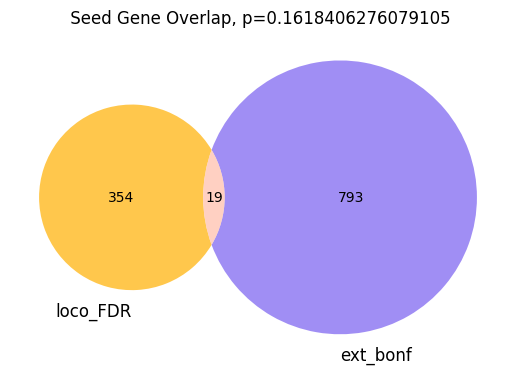

In [33]:
venn_seeds(seed_r, seed_h, label_r, label_h, colour_dict['loco'],colour_dict['ext'],all_nodes,interactome_name, savefig=save_fig)

# compare stats

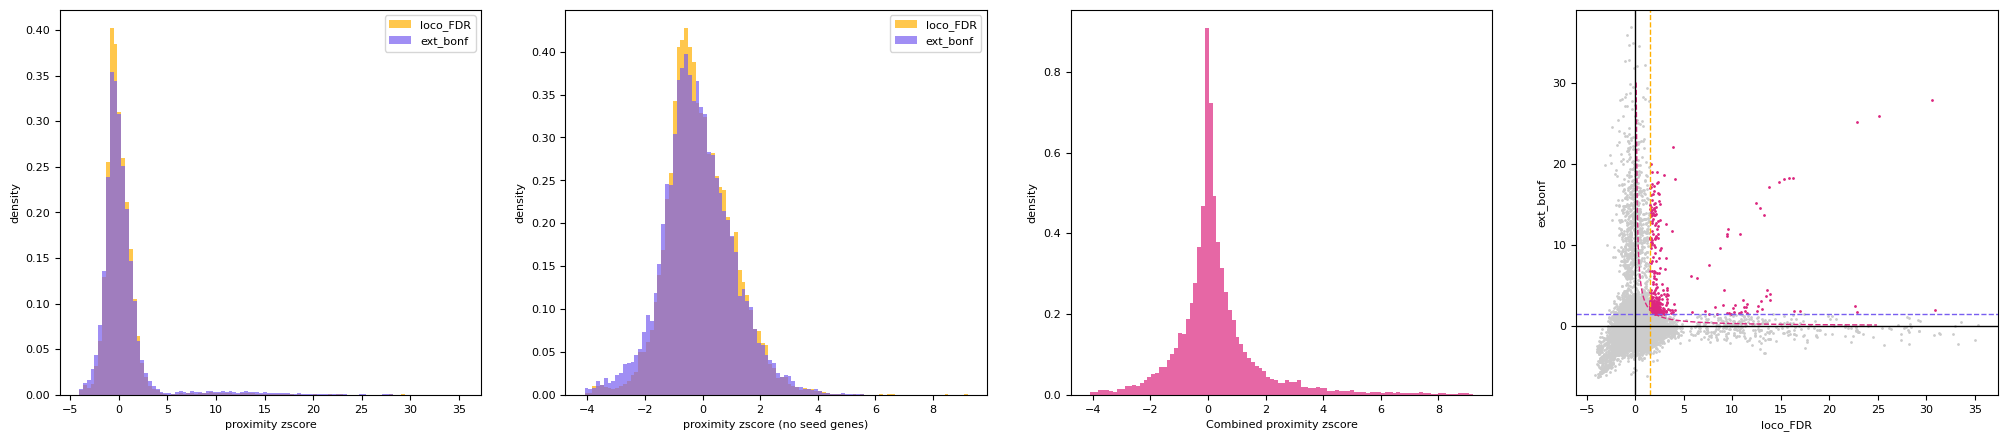

In [98]:
#import rare seed gene list and NPS scores
plt_histogram(tblr=NPS_r, tblc=NPS_h, 
              tblr_label=label_r, tblc_label=label_h,
              tblr_seed=seed_dict['loco_FDR'], tblc_seed=seed_dict['ext_FDR'], 
              colour_r=colour_dict['loco'],colour_c=colour_dict['ext'],colour_shared=colour_dict['shared'],
              tblr_lim=1.5,
              tblc_lim=1.5,
              comb_lim=3,
              savefig=save_fig,
             filename='NPS_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)


In [35]:
#set the Z-score cutoffs to calculate network enrichment significance
zlist = [1,2,3,4,5,6,7,8,9,10]
z12list = [1,1.5,2,3,4,5]
cutoff_comb=3
cutoff_single=1.5

In [36]:
netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(NPS_r,NPS_h,
                                                                             zthresh_list = zlist,
                                                                             z12thresh_list=z12list,
                                                                             verbose=False)
#netcoloc_enrichment_df=netcoloc_enrichment_df[netcoloc_enrichment_df['z_comb']>=netcoloc_enrichment_df['NPS_single']]
print(netcoloc_enrichment_df)
netcoloc_enrichment_df['rare_dataset']='loco_bonf'
netcoloc_enrichment_df['common_dataset']='ext_bonf'
if save_fig:
    netcoloc_enrichment_df.to_csv('colocalization_scores/colocScore_'+label_r+'_'+label_h+'_'+interactome_name+'.tsv',sep='\t',index=False)
pOverlap=float(netcoloc_enrichment_df[(netcoloc_enrichment_df['z_comb']==cutoff_comb) & (netcoloc_enrichment_df['z_12']==cutoff_single)]['empirical_p'])

    z_comb  z_12  observed_overlap  expected_overlap_mean  \
0        1   1.0               928                 750.01   
1        1   1.5               385                 285.48   
2        1   2.0               143                 113.70   
3        1   3.0                38                  31.99   
4        1   4.0                22                  18.17   
5        1   5.0                19                  16.32   
6        2   1.0               750                 599.38   
7        2   1.5               385                 283.50   
8        2   2.0               143                 111.13   
9        2   3.0                38                  30.98   
10       2   4.0                22                  18.99   
11       2   5.0                19                  16.31   
12       3   1.0               556                 431.58   
13       3   1.5               365                 263.82   
14       3   2.0               143                 113.31   
15       3   3.0        

1.5
365


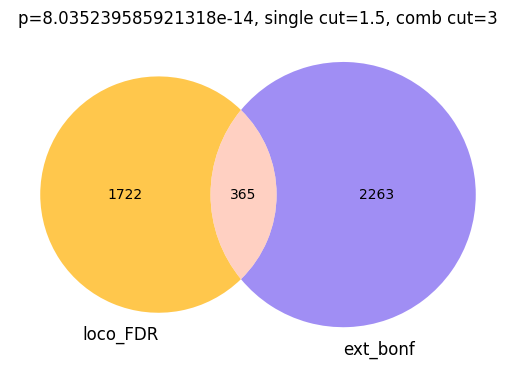

In [37]:
venn_net(tblr=NPS_r,tblc=NPS_h, tblr_label=label_r,tblc_label= label_h,p_net_overlap=pOverlap,
         colour_r=colour_dict['loco'],colour_c=colour_dict['ext'],colour_shared=colour_dict['shared'],
         tblr_lim=1.5, tblc_lim=1.5, comb_lim=3, savefig=save_fig)

## histogram observed vs permuted network size

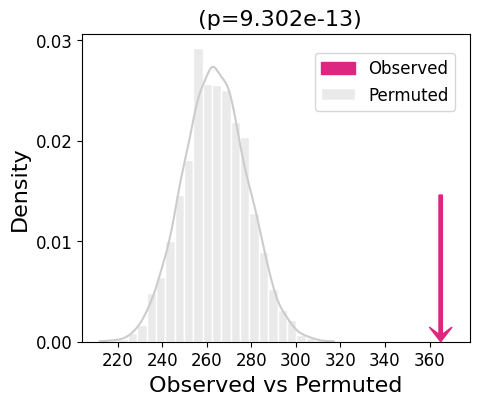

In [38]:
observed_sz, permuted_sz = network_colocalization.calculate_expected_overlap(NPS_r.iloc[:,0], NPS_h.iloc[:,0], 
                                                            z_score_threshold=cutoff_comb, z1_threshold=cutoff_single,
                                                            z2_threshold=cutoff_single, num_reps=10000, plot=False)                                                                   
plot_permutation_histogram(permuted_sz, observed_sz, title="", xlabel="Observed vs Permuted", color=colour_dict['other'], arrow_color=colour_dict['shared'],
                           savefig=save_fig, filename='networksize_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)

## histogram observed vs permuted mean NPS

Overlap seed genes: 19


100%|██████████| 1000/1000 [00:04<00:00, 228.09it/s]


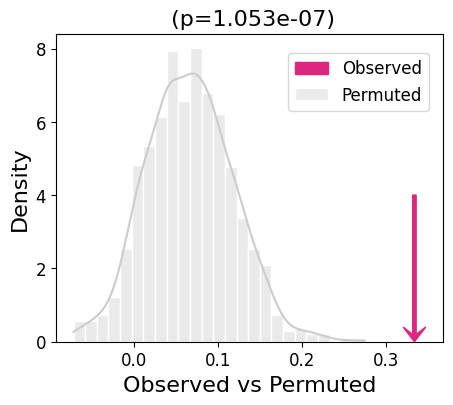

In [41]:
# Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
observed_net, permuted_net = calculate_mean_z_score_distribution(NPS_r.iloc[:,0], NPS_h.iloc[:,0], num_reps=1000,
                                                        zero_double_negatives=False, overlap_control="remove",
                                                        seed1=list(set(seed_r).intersection(all_nodes)), seed2=list(set(seed_h).intersection(all_nodes)))
plot_permutation_histogram(permuted_net, observed_net, title="", xlabel="Observed vs Permuted", color=colour_dict['other'], arrow_color=colour_dict['shared'],savefig=False, 
                           filename='mean_NPScr_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)

# sensitivity analysis -NPS scores

In [49]:
if ('netcoloc_enrichment_df' not in vars()):
    netcoloc_enrichment_df=pd.read_csv('colocalization_scores/colocScore_'+label_r+'_'+label_h+'_'+interactome_name+'.tsv',sep='\t')

In [53]:
netcoloc_enrichment_df.head()

,z_comb,z_12,observed_overlap,expected_overlap_mean,expected_overlap_std,empirical_p,obs_exp,rare_dataset,common_dataset
0,1,1.0,928,750.01,23.553978,2.067355e-14,1.237317,loco_bonf,ext_bonf
1,1,1.5,385,285.48,13.731336,2.120233e-13,1.348606,loco_bonf,ext_bonf
2,1,2.0,143,113.70,10.420653,2.463838e-03,1.257696,loco_bonf,ext_bonf
3,1,3.0,38,31.99,4.685072,9.978147e-02,1.187871,loco_bonf,ext_bonf
4,1,4.0,22,18.17,4.485655,1.965988e-01,1.210787,loco_bonf,ext_bonf


In [54]:
netcoloc_enrichment_df['logp']=-np.log10(netcoloc_enrichment_df['empirical_p'])
netcoloc_enrichment_df.columns=['NPS_common-rare', 'NPS_single', 'observed_overlap', 'expected_overlap_mean',
       'expected_overlap_std', 'empirical_p', 'obs_exp', 'rare_dataset',
       'common_dataset', 'logp']

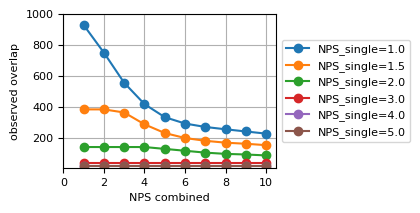

In [74]:
NPS_lineplot(netcoloc_enrichment_df,'observed_overlap','network_overlap_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[10,1000],savefig=save_fig)

/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/rca_functions.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


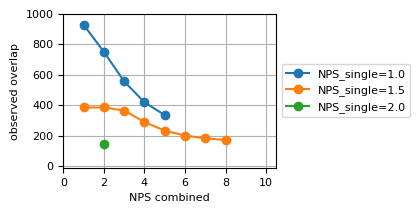

In [75]:
NPS_lineplot(temp,'observed_overlap','network_overlap_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5], yrange=[-10,1000],savefig=save_fig)

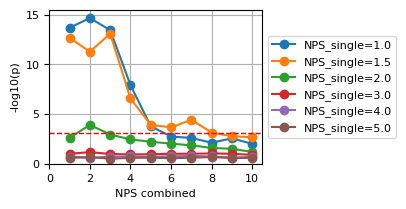

In [63]:
NPS_lineplot(netcoloc_enrichment_df,'-log10(p)','network_overlap_pval_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[0,15.5], savefig=save_fig,sigline=True)

/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/rca_functions.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


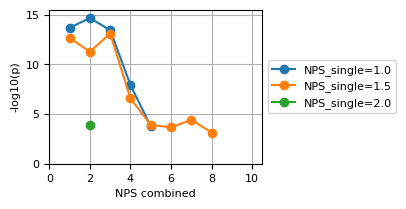

In [70]:
NPS_lineplot(temp,'-log10(p)','network_overlap_pval_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5], yrange=[0,15.5],savefig=save_fig)

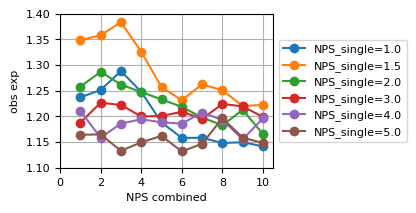

In [66]:
NPS_lineplot(netcoloc_enrichment_df,'obs_exp','network_overlap_obsexp_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[1.1,1.4],savefig=save_fig)

/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/rca_functions.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


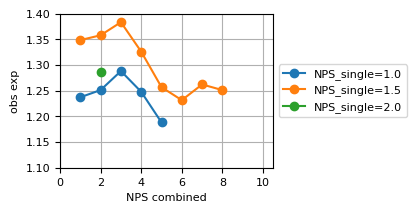

In [68]:
temp=netcoloc_enrichment_df[netcoloc_enrichment_df['empirical_p']<0.05/len(netcoloc_enrichment_df)]

NPS_lineplot(temp,'obs_exp','network_overlap_obsexp_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[1.1,1.4],savefig=save_fig)

# generate colocalized locomotor-ext network (unannotated)- save to ndexbio

In [121]:
pd.Series(NPS_h['z'])

0
TGFBR1           -0.371810
TGFBR2            0.353783
SMAD3            -0.080502
TGFB1             0.698732
SMAD2            -0.261657
                    ...   
TRBV5-1          -0.608840
TRBV19           -0.604279
TRAV12-3         -0.590589
TRAV22           -0.516310
ARMCX5-GPRASP2   -0.184316
Name: z, Length: 19267, dtype: float64

In [134]:
net=network_colocalization.calculate_network_overlap_subgraph(
    graph, pd.Series(NPS_r['z']), pd.Series(NPS_h['z']), cutoff_comb, cutoff_single, cutoff_single)
net2=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])
print(net2.nodes())
if save_fig:
    print('exporting network to NDEx')
    export_network(network=net, name=(label_r+'_'+label_h+'_'+interactome_name+'_MAGMA'), user=ndex_user, password=ndex_password)

exporting network to NDEx
bsleger
supnu8-muqsov-hobpUb
Generating CX


In [137]:
colour_dict['shared']

'#DC267F'